In [2]:
# Data analysis and wrangling
import pandas as pd
import numpy as np
import os
import string
import csv

# Visualization
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import missingno
import plotly.graph_objects as go
from mpl_toolkits.mplot3d import Axes3D
import plotly as py
import plotly.subplots
import plotly.graph_objects as go

# Model prediction
from tensorflow import keras
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from tensorflow.keras import backend, models, layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, LSTM

In [3]:
df = pd.read_csv('climate.csv', 
                    header = 0, 
                    error_bad_lines=False,
                    engine='python')

pd.set_option('display.max_columns', None)   

<ipython-input-3-853c43b2b498>:1: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  df = pd.read_csv('climate.csv',


## EDA, Data cleaning, preparation and processing

In [4]:
df.head()

,date,temperature_mean,temperature_max,temperature_min
0,1/1/1950,17.6,24.2,11.6
1,1/2/1950,17.1,23.0,11.8
2,1/3/1950,17.6,23.0,12.1
3,1/4/1950,15.8,19.8,11.6
4,1/5/1950,16.3,21.1,11.6


In [5]:
df.tail()

,date,temperature_mean,temperature_max,temperature_min
26813,5/31/2023,30.8,35.1,27.1
26814,6/1/2023,30.8,35.0,27.2
26815,6/2/2023,31.0,35.6,27.1
26816,6/3/2023,29.9,34.3,27.0
26817,6/4/2023,29.0,31.6,27.0


In [6]:
# df.rename(columns = {'AWND': 'WINDAVG',
#                      'PRCP': 'PRECIPITATION',
#                      'temperature_mean': 'TEMPAVG_F', 
#                      'temperature_max': 'TEMPMAX_F', 
#                      'temperature_min': 'TEMPMIN_F'}, inplace=True)

df.rename(columns = {'date' : 'DATE',
                    'temperature_mean': 'TEMPAVG_F', 
                     'temperature_max': 'TEMPMAX_F', 
                     'temperature_min': 'TEMPMIN_F'}, inplace=True)

## Visualizing the weather data

<Axes: title={'center': 'Temperature'}, xlabel='DATE'>

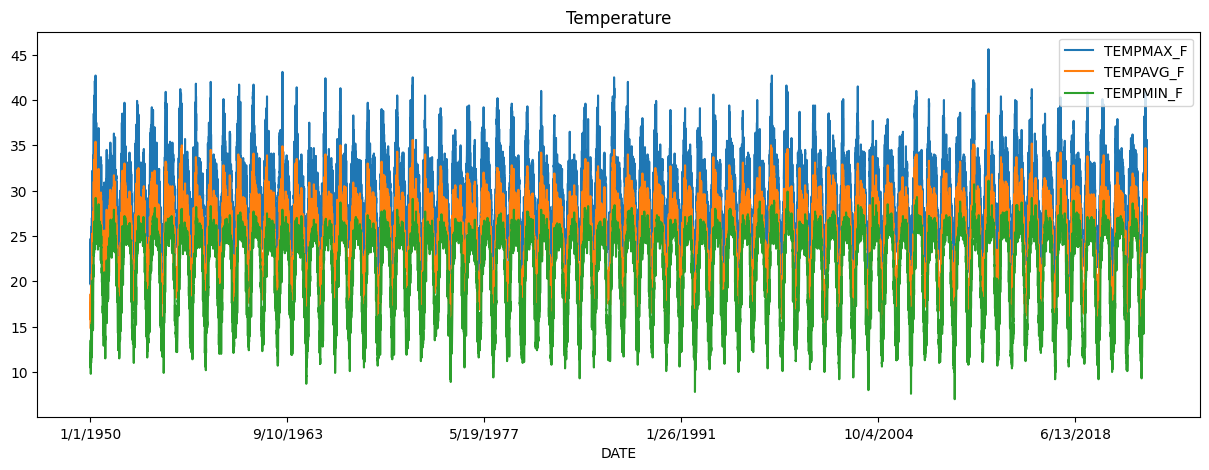

In [7]:
# Timeline plot of the daily temperatures
df.plot(x='DATE', y=['TEMPMAX_F', 'TEMPAVG_F', 'TEMPMIN_F'], figsize=(15,5), title='Temperature')

<Axes: xlabel='TEMPMAX_F', ylabel='TEMPMIN_F'>

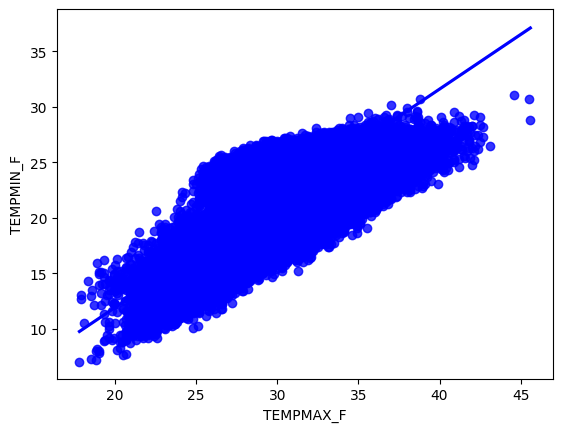

In [8]:
# Scatter plot between the min and max temperatures

sns.regplot(x = 'TEMPMAX_F', y = 'TEMPMIN_F', color="b", data = df)

#### From the above figure, 0 = No Rain and 1 = Rain

In [9]:
# Visualing the Precipitation

# fig = go.Figure(data=[go.Scatter(x=df1['DATE'], y=df1['PRECIPITATION'])],
#                 layout=go.Layout(title=go.layout.Title(text='Precipitation - Rain in Inches')))

# fig.show()

#### As shown on the plot, the highest one day precipitation (rainfall): 16.07 inches - August 27, 2017

In [10]:
# View data to be used for rain prediction

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26818 entries, 0 to 26817
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   DATE       26818 non-null  object 
 1   TEMPAVG_F  26818 non-null  float64
 2   TEMPMAX_F  26818 non-null  float64
 3   TEMPMIN_F  26818 non-null  float64
dtypes: float64(3), object(1)
memory usage: 838.2+ KB


### Recurrent Neural Networks LSTM -- Time Series predicting (forecasting)

In [11]:
# Use Temperature data from Jan-01-2016 to July-09-2020

df_temp = df[['TEMPAVG_F']]
df_temp.index = pd.to_datetime(df[['DATE']].stack(), format='%m%d%y', errors='ignore')

df_temp.head()

,TEMPAVG_F
1/1/1950,17.6
1/2/1950,17.1
1/3/1950,17.6
1/4/1950,15.8
1/5/1950,16.3


<Axes: title={'center': 'Time Series'}>

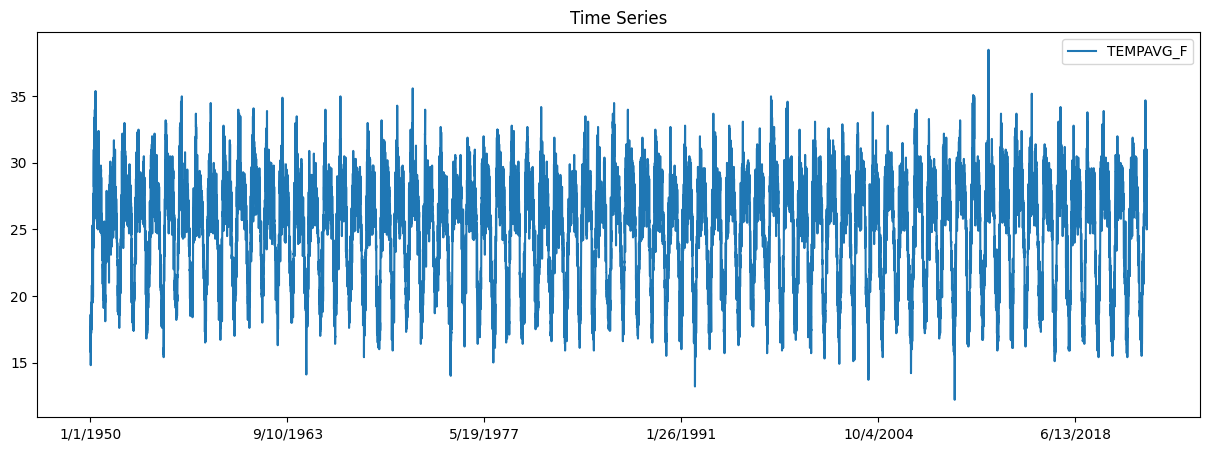

In [12]:
# Plot the Time Series for the Temperature
df_temp.plot(figsize=(15,5), title='Time Series')

### Prepare data for training

In [13]:
# Split into training and test data

train_size = int(len(df_temp) * 0.8)
test_size = len(df_temp) - train_size
train, test = df_temp.iloc[0:train_size], df_temp.iloc[train_size:len(df_temp)]
print(len(train), len(test))

21454 5364


In [14]:
# Scaling the data with MinMaxScaler

scaler = MinMaxScaler()
scaler = scaler.fit(train[['TEMPAVG_F']])

train['TEMPAVG_F'] = scaler.transform(train[['TEMPAVG_F']])
test['TEMPAVG_F'] = scaler.transform(test[['TEMPAVG_F']])

<ipython-input-14-bba6c2e3ad03>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['TEMPAVG_F'] = scaler.transform(train[['TEMPAVG_F']])
<ipython-input-14-bba6c2e3ad03>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['TEMPAVG_F'] = scaler.transform(test[['TEMPAVG_F']])


#### Create sequences

In [15]:
# Creating sequences combining with time_steps

def create_sequences(X, y, time_steps=1):
    X_output, y_output = [], []
    for i in range(len(X) - time_steps):
        value = X.iloc[i:(i + time_steps)].values
        X_output.append(value)        
        y_output.append(y.iloc[i + time_steps])
    return np.array(X_output), np.array(y_output)

In [16]:
# Use a history of 5 time steps to make our sequences

time_steps = 5

X_train, y_train = create_sequences(train, train.TEMPAVG_F, time_steps)
X_test, y_test = create_sequences(test, test.TEMPAVG_F, time_steps)

print(X_train.shape, y_train.shape)

(21449, 5, 1) (21449,)


### Build a model

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128)               66560     
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 66,689
Trainable params: 66,689
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
1341/1341 [==============================] - 15s 6ms/step - loss: 0.0063 - val_loss: 0.0035
Epoch 2/50
1341/1341 [==============================] - 5s 4ms/step - loss: 0.0032 - val_loss: 0.0021
Epoch 3/50
1341/1341 [==============================] - 6s 4ms/step - loss: 0.0023 - val_loss: 0.0020
Epoch 4/50
1341/1341 [==============================] - 6s 4ms/step - loss: 0.0023 - val_loss: 0.0020
Epoch 5/50
1341/1341 [=================

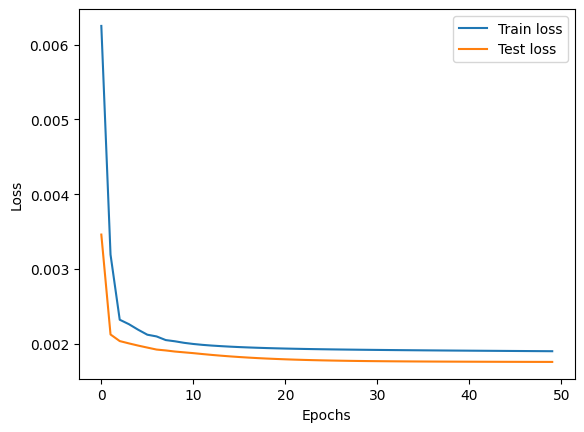

In [17]:
# Use the LSTM layer in a sequential model to make temperature predictions.

backend.clear_session()

model = keras.Sequential()

# inputs = keras.layers.Input(input_shape=(X_train.shape[1], X_train.shape[2]))
# lstm_out = keras.layers.LSTM(128)(inputs)
# outputs = keras.layers.Dense(1)(lstm_out)


model.add(keras.layers.LSTM(128, input_shape=(X_train.shape[1], X_train.shape[2])))
# model.add(keras.layers.LSTM(128, input_shape=(X_train.shape[1], X_train.shape[2])))

# model.add(keras.layers.dropout(0.2))
# model.add(keras.layers.LSTM(128))
# model.add(Dropout(0.2))
# model.add(Dense(1, activation='sigmoid'))
model.add(keras.layers.Dense(1))

# model = keras.Model(inputs=inputs, outputs=outputs)

# Compile the model
model.compile(loss='mean_squared_error',
              optimizer=keras.optimizers.Adam(0.001))
model.summary()

# Train the model
history = model.fit(X_train, 
                    y_train, 
                    epochs=50, 
                    batch_size=16, 
                    validation_data = (X_test, y_test),
                    verbose=1, 
                    shuffle=False)

plt.plot(history.history['loss'], label='Train loss')
plt.plot(history.history['val_loss'], label='Test loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

results = model.evaluate(X_test, y_test)
print(model.metrics_names)
print(results)

#### From the above plot, after ~ 25 epochs, the model is pretty much done of learning.

### Model prediction

In [18]:
y_pred = model.predict(X_test)

168/168 [==============================] - 1s 2ms/step


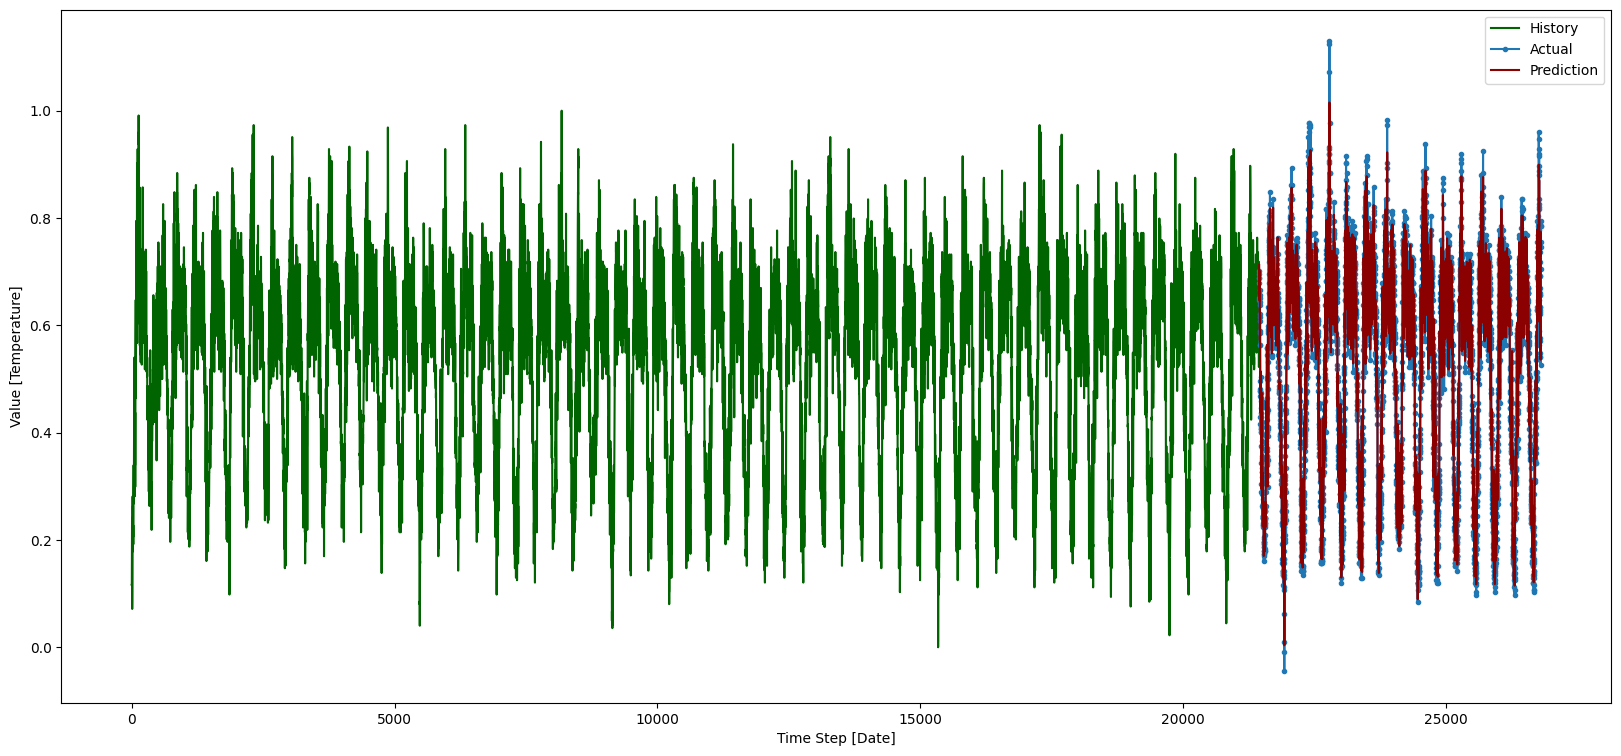

In [21]:
# Plot the predictions over the true (actual) values from the Time Series.

plt.figure(figsize=(20, 9))
plt.plot(np.arange(0, len(y_train)), y_train, 'darkgreen', label="History")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_test, marker='.', label="Actual")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_pred, 'darkred', label="Prediction")
plt.ylabel('Value [Temperature]')
plt.xlabel('Time Step [Date]')
plt.legend()
plt.show()

#### From the above plot, the predictions over the true (actual) values from the Time Series look very good.

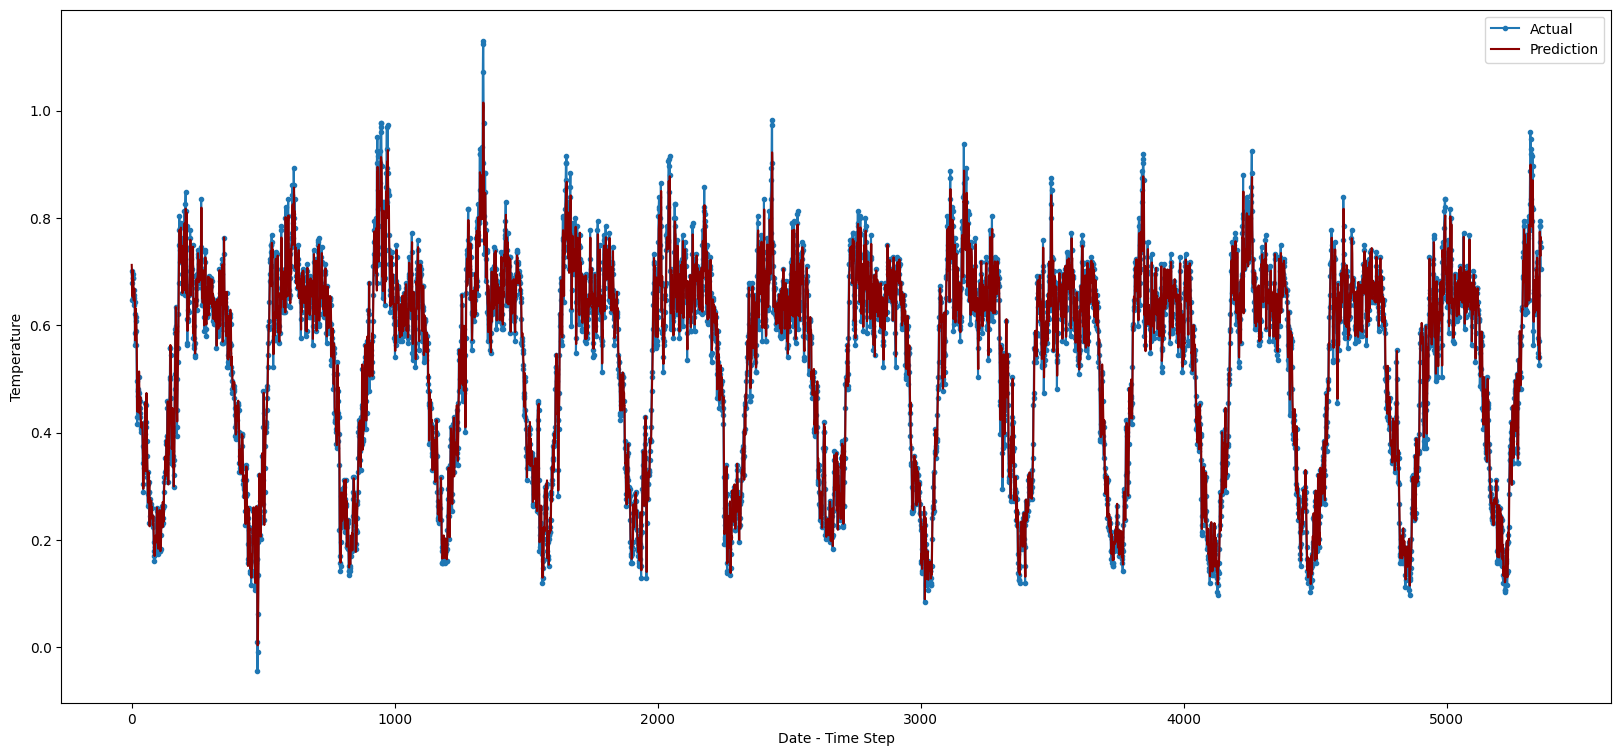

In [22]:
# Get a closer visualization of the predictions from the Time Series.

plt.figure(figsize=(20, 9))
plt.plot(y_test, marker='.', label="Actual")
plt.plot(y_pred, 'darkred', label="Prediction")
plt.ylabel('Temperature')
plt.xlabel('Date - Time Step')
plt.legend()
plt.show()